# IEQ and Survey Response Analysis
Exploring the relationship between the categorical survey responses from the EMA and the IEQ measurements from the Beacon

In [1]:
import warnings
warnings.filterwarnings('ignore')

# IEQ Prior to Mood Reports
We want to know if the IEQ affected participants' mood scores when EMAs were submitted at home and participants were home prior to submission.

In [2]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.cm import ScalarMappable

from scipy import stats
from sklearn.linear_model import LinearRegression

<a id='toc'></a>

# Table of Contents

1. [Data Import](#data_import)
2. [Pre-Processing](#pre_processing)
3. [Inspection](#inspection)
4. [Analysis](#analysis)

---

<a id='data_import'></a>

[Back to ToC](#toc)
# Data Import
We have two datasets to import:

## EMAs Completed at Home
Intersection between GPS coordinates, home address, and the completion of the EMAs.

In [3]:
ema = pd.read_csv("../data/processed/beiwe-ema_at_home_v2-ux_s20.csv",index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
for column in ema.columns:
    if column != "beiwe":
        ema[column] = pd.to_numeric(ema[column])
ema.head()

,beiwe,content,stress,lonely,sad,energy,redcap,beacon,time_at_home
timestamp,,,,,,,,,
2020-05-15 09:21:05,mm69prai,1.0,0.0,1.0,1.0,1.0,62,13.0,10412.0
2020-05-15 09:25:04,vr9j5rry,2.0,0.0,0.0,0.0,3.0,34,25.0,29405.0
2020-05-15 12:02:43,kyj367pi,2.0,0.0,1.0,0.0,2.0,10,1.0,3774.0
2020-05-15 12:59:31,lkkjddam,1.0,1.0,2.0,1.0,2.0,12,21.0,5536.0
2020-05-15 17:28:54,9jtzsuu8,2.0,1.0,0.0,0.0,2.0,36,15.0,31643.0


## IEQ Data

In [4]:
ieq = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
ieq.drop(["beacon","redcap","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2","lux","co"],axis=1,inplace=True)
for column in ieq.columns:
    if column != "beiwe":
        ieq[column] = pd.to_numeric(ieq[column])
ieq.head()

,tvoc,co2,pm2p5_mass,temperature_c,rh,beiwe,fitbit
timestamp,,,,,,,
2020-06-08 13:00:00,59.283485,NaN,24.767709,16.244700,46.586667,kyj367pi,24.0
2020-06-08 13:02:00,59.501238,NaN,25.379307,16.257887,46.581250,kyj367pi,24.0
2020-06-08 13:04:00,60.484807,NaN,24.874103,16.269523,46.597059,kyj367pi,24.0
2020-06-08 13:06:00,61.532057,NaN,24.503767,16.279865,46.619444,kyj367pi,24.0
2020-06-08 13:08:00,62.381287,NaN,24.824221,16.289119,46.639474,kyj367pi,24.0


[Back to Data Import](#data_import)

---

<a id='pre_processing'></a>

[Back to ToC](#toc)
# Pre-Processing

## Getting IEQ Summary Stats Prior to Submission
The summary stats that we will consider during the period prior to submission are:
* **Mean**: mean concentration
* **Max**: max concentration
* **Sum**: cumulative concentration 
* **Range**: difference in maximum and minimum concentration
* **Delta**: change in concentration between initial occupancy and EMA submission (final - initial)

In [5]:
def get_ieq_measurements(ieq, ema, window=10, min_time_at_home=60, percentile=0.9):
    """
    Summarizes IEQ measurements for a given period prior to submission of the EMA
    
    Parameters
    ----------
    ieq : DataFrame
        IEQ data for a given participant
    ema: DataFrame
        EMA submissions for a given participant
    window : int, boolean, default 10
        Number of minutes to consider before EMA submission. If True, then uses the entire 
        time prior to submission as determined by GPS traces from Beiwe.
    min_time_at_home : int, default 60
        minimum number of seconds the participant has to be at home
    
    Returns
    -------
    ema_and_iaq : DataFrame
        original dataframe with summarized IEQ parameters
    """
    # ensuring timestamp is index of ema
    try:
        ema.set_index("timestamp",inplace=True)
    except KeyError:
        # assuming "timestamp" is the index
        pass
    ema_and_ieq = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        ieq_pt = ieq[ieq["beiwe"] == pt]
        ema_pt = ema[ema["beiwe"] == pt]
        ieq_pt.drop("beiwe",axis=1,inplace=True)
        # summary stat DFs
        ieq_prior_mean = pd.DataFrame()
        ieq_prior_max = pd.DataFrame()
        ieq_prior_sum = pd.DataFrame()
        ieq_prior_range = pd.DataFrame()
        ieq_prior_delta = pd.DataFrame()
        ieq_prior_percentile = pd.DataFrame()
        for t in ema_pt.index:
            if window == True:
                try:
                    t_at_home = ema_pt.loc[t,"time_at_home"]
                    if t_at_home > min_time_at_home:
                        s = t - timedelta(seconds=t_at_home)
                    else:
                        s = t
                except KeyError as e:
                    print(e)
                    return
            else:
                s = t - timedelta(minutes=window)
            ieq_prior = ieq_pt[s:t]
            if len(ieq_prior) > 0:
                ieq_prior_mean = pd.concat([ieq_prior_mean,ieq_prior.mean(axis=0)],axis=1)
                ieq_prior_max = pd.concat([ieq_prior_max,ieq_prior.max(axis=0)],axis=1)
                ieq_prior_range = pd.concat([ieq_prior_range,ieq_prior.max(axis=0) - ieq_prior.min(axis=0)],axis=1)
                ieq_prior_delta = pd.concat([ieq_prior_delta,ieq_prior.iloc[-1,:] - ieq_prior.iloc[0,:]],axis=1)
                ieq_prior_sum = pd.concat([ieq_prior_sum,ieq_prior.sum(axis=0,numeric_only=True)],axis=1)
                ieq_prior_percentile = pd.concat([ieq_prior_percentile,ieq_prior.quantile(percentile,axis=0,numeric_only=True)],axis=1)

        # mean
        ieq_prior_mean = ieq_prior_mean.T
        ieq_prior_mean.columns  = [col+"_mean" for col in ieq_prior_mean.columns]
        # max
        ieq_prior_max = ieq_prior_max.T
        ieq_prior_max.columns  = [col+"_max" for col in ieq_prior_max.columns]
        # sum
        ieq_prior_sum = ieq_prior_sum.T
        ieq_prior_sum.columns  = [col+"_sum" for col in ieq_prior_sum.columns]
        # range
        ieq_prior_range = ieq_prior_range.T
        ieq_prior_range.columns  = [col+"_range" for col in ieq_prior_range.columns]
        # delta
        ieq_prior_delta = ieq_prior_delta.T
        ieq_prior_delta.columns  = [col+"_delta" for col in ieq_prior_delta.columns]
        # percentile
        ieq_prior_percentile = ieq_prior_percentile.T
        ieq_prior_percentile.columns = [col+f"_{percentile}" for col in ieq_prior_percentile.columns]

        ema_ieq_pt = pd.concat([ema_pt.reset_index(),
                                ieq_prior_mean.reset_index(drop=True),
                                ieq_prior_max.reset_index(drop=True),
                                ieq_prior_sum.reset_index(drop=True),
                                ieq_prior_range.reset_index(drop=True),
                                ieq_prior_delta.reset_index(drop=True),
                                ieq_prior_percentile.reset_index(drop=True)],axis=1)
        ema_and_ieq = ema_and_ieq.append(ema_ieq_pt)

    return ema_and_ieq

In [6]:
ema_ieq = get_ieq_measurements(ieq,ema,window=True)

In [7]:
print("Number of Participants:", len(ema_ieq.dropna()["beiwe"].unique()))

Number of Participants: 20


## Discontent Over Content
Three of the four mood scores are negative i.e. for a good score, you want to rate your mood low whereas the `content` score is the opposite. We can get around this by defining a `discontent` score which will simply be the opposite of `content`.

In [8]:
ema_ieq["discontent"] = 3 - ema_ieq["content"]
ema["discontent"] = 3 - ema["content"]

In [11]:
ema_ieq.to_csv("../data/interim/beiwe-beacon-evening_ema_home-ieq_summary_home.csv")

In [14]:
print(f"Number of Datapoints: {len(ema_ieq)}")
print(f"Number of Participants: {len(ema_ieq['beiwe'].unique())}")

Number of Datapoints: 821
Number of Participants: 27


## Binarizing Dataset
Various analyses might perform better if we binarize the mood scores and/or the IEQ measurements. In the following cells, we create all the possible combinations of binarized datasets.

### "Low" and "High" Mood
0 and 1 -> Low

2 and 3 -> High

In [15]:
ema_bi = ema.copy()
ema_bi_ieq = ema_ieq.copy()
for mood in ["content","discontent","stress","lonely","sad","energy"]:
    if mood in ["content","discontent","energy"]:
        ema_bi[mood] = [0 if score < 2 else 1 for score in ema_bi[mood]]
        ema_bi_ieq[mood] = [0 if score < 2 else 1 for score in ema_bi_ieq[mood]]
    else:
        ema_bi[mood] = [0 if score == 0 else 1 for score in ema_bi[mood]]
        ema_bi_ieq[mood] = [0 if score == 0 else 1 for score in ema_bi_ieq[mood]]

### Binarizing IAQ Based on Participant-Specific Values
Rather than consider IAQ thresholds which provide a host of their own issues (participant adaptation, measurements all above or below threshold, etc.), we binarize IAQ as good or bad based on the mean concentration the participant experienced during the study period. 

In [139]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [140]:
def get_binary_ieq(df,raw_ieq,pollutants=["co2","tvoc","pm2p5_mass","temperature_c","rh"]):
    """
    Gets the binary encoding of the vars in pollutants for each participant
    
    Inputs:
        - df: dataframe with mean pollutant concentrations
        - raw_ieq: dataframe of the unaltered ieq data from the entire deployment
        - pollutants: list of strings corresponding to the IEQ parameters of interest - must have corresponding columns in the other two dataframes
    """
    df_bi = pd.DataFrame()
    for pt in df["beiwe"].unique():
        df_pt = df[df["beiwe"] == pt]
        ieq_pt = raw_ieq[raw_ieq["beiwe"] == pt]
        for pollutant in pollutants:
            try:
                mean_night = np.nanmean(ieq_pt[f"{pollutant}"])
            except KeyError as e:
                print(f"Exiting: {e} not in the raw IEQ data")
                return
            
            df_pt[f"{pollutant}_binary"] = df_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_mean"],mean_night), axis="columns")

        df_bi = df_bi.append(df_pt)

    return df_bi

In [141]:
ema_bi_ieq_bi = get_binary_ieq(ema_bi_ieq,ieq)

[Back to Pre-Processing](#pre_processing)

---

<a id='inspection'></a>

[Back to ToC](#toc)
# Inspection
Various functions and initial looks at the raw and pre-processed data.

In [16]:
def get_mood_distribution(df_in,moods=["discontent","stress","lonely","sad","energy"],plot=False):
    """
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the scores
        
    Returns
    -------
    df : DataFrame
        
    """
    res = {mood: [] for mood in moods}
    df = df_in.copy()
    for mood in moods:
        df[f"{mood}"] = pd.to_numeric(df[f"{mood}"])
    if plot:
        _, axes = plt.subplots(1,len(moods),figsize=(len(moods)*4,3),sharey="row",sharex="col")
        for mood, ax in zip(moods,axes):
            dist = df[f"{mood}"].value_counts()
            ax.bar(dist.index,dist.values/dist.sum(),edgecolor="black",color="lightgray")
            for score, height in zip(dist.index,dist.values/dist.sum()):
                ax.text(score,height+0.05,round(height*100,1),ha="center")
            ax.set_ylim([0,1])
                
            ax.set_xlabel(mood.title(),fontsize=12)

            # appending results to output
            res[mood].append(dist.values)

            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            
        plt.show()
        plt.close()
        
    return pd.DataFrame(data=res)

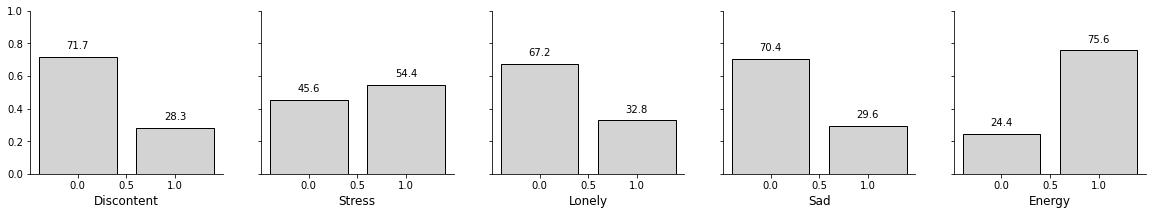

,discontent,stress,lonely,sad,energy
0,"[589, 232]","[447, 374]","[552, 269]","[578, 243]","[621, 200]"


In [17]:
get_mood_distribution(ema_bi_ieq,plot=True)

## Typical Times at Home
We can start by inspecting the typical times that participants were at home prior to submitting their survey.

In [144]:
def plot_time_at_home(df,unit="minutes",bins=np.arange(0,35,5)):
    """plots histogram of times spent at home with given unit and bins"""
    fig, ax = plt.subplots()
    if unit == "minutes":
        divisor = 60
    elif unit == "hours":
        divisor = 3600
    else:
        divisor = 1
        unit = "seconds"
        
    ax.hist(ema["time_at_home"]/divisor,bins=bins,edgecolor="black",color="grey")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

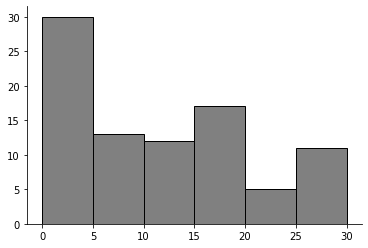

In [145]:
plot_time_at_home(ema)

[Back to Inspection](#inspection)

---

<a id='analysis'></a>

[Back to ToC](#toc)
# Analysis
The following is the general analysis that follows:
1. **[IEQ distributions for low and high mood](#ieq_distributions)**: This process helps us avoid determining if IEQ parameters are "good" or "bad" by simply looking at the meausrements made prior to the EMA submitted at home. We do have to consider analysis on two-levels:
    1. **Population-Level**: A general overview that can pull-in bias from participants
    2. **Individual-Level**: More specific analysis where we can combine the results on a per-participant level in a meaningful way to help reduce bias.
2. **[IEQ and mood summarized over the _entire_ study](#ieq_and_mood)**: Summarize the IEQ parameters in various ways and summarize the mood scores and compare them. Each participant corresponds to one datapoint. We still only consider the EMAs that are completed at home though since _so_ many other factors could go into determining the mood elsewhere.
2. **[Time dependence on mood](#time_dependence)**: This analysis considers the time spent at home as a parameter in addition to the type of activity conducted during that time. We need to consider such things as:
    1. **Acclimation**: Do participants tend to acclimate to their IEQ parameters after a while? 
    2. **Exposure estimates**: Inhalation rates might vary by participant so concentrations might be lower for one participant, but if their inhalation rate is greater then they are really exposed to a _greater_ concentration.
    3. **Activity level**: we can get this information from Fitbit and/or Beiwe, but on a more macro-level the big question is whether or not to include sleeping times since you are unconscious during this period.
3. **[Contingency tables](#contingency)**: A more statistical look at the relationship between low and high IEQ and mood parameters
4. **[Mood and ventilation rate](#mood_and_ach)**: Rather than consider all IEQ parameters, perhaps we can simplify things to just the ventilation rate and use that as a proxy for IAQ.

<a id='ieq_distributions'></a>

## IEQ Distributions for Low and High Mood Scores
The first part of the analysis is examining the difference in IEQ distributions when participants moods are low or high. 

### Aggregate
Since we had the code to visualize and calculate p-values, we pull that in here and visualize the distributions in addition to providing the p-values.

In [64]:
def plot_mood_violin_per_ieq(df_in,ieq_params=["co2","tvoc","pm2p5_mass","temperature_c","rh"],summary_stat="mean",moods=["discontent","stress","lonely","sad","energy"],label="",save=False):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    # creating dictionary to store p-values
    ttest_results = {}
    fig, axes = plt.subplots(len(ieq_params),1,figsize=(4*len(moods),4*len(ieq_params)),sharex=True)
    for ieq_param, title, ax in zip(ieq_params,["a","b","c","d","e","f"],axes.flat):
        df_expanded = df_in.melt(id_vars=[c for c in df_in.columns if c.endswith(summary_stat)],value_vars=moods)
        g = sns.violinplot(x="variable",y=f"{ieq_param}_{summary_stat}",hue="value",data=df_expanded,
                       split=True,inner=None,hue_order=[0,1],palette={0:"white",1:"#bf5700"},cut=0,ax=ax,legend_out=False)
        # x-axis
        ax.set_xticklabels([mood.title() for mood in moods],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(ieq_param),fontsize=label_fs)
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        if ieq_param == "rh":
            ax.legend(handles=g.get_children(),labels=["Low","High"],loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Mood Score")
        else:
            ax.get_legend().remove()
        
        pvals = pd.DataFrame()
        for mood in moods:
            df = df_expanded[df_expanded["variable"] == mood]
            low_vals = df[df["value"] == 0]
            high_vals = df[df["value"] == 1]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[f"{ieq_param}_{summary_stat}"],high_vals[f"{ieq_param}_{summary_stat}"], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"mood":[mood.title()],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[f"{ieq_param}_{summary_stat}"])],"mean_high":np.nanmean(high_vals[f"{ieq_param}_{summary_stat}"]),"p":[p]}))

        ttest_results[ieq_param] = pvals.set_index("mood")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[ieq_param]["p"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
        
    if save:
        plt.savefig(f"../reports/figures/beiwe-beacon-mood_bi{'_'+label}-ieq_{summary_stat}{'_'+label}-violin-ux_s20.pdf",bbox_inches="tight")
    plt.show()
    plt.close()
    
    return ttest_results

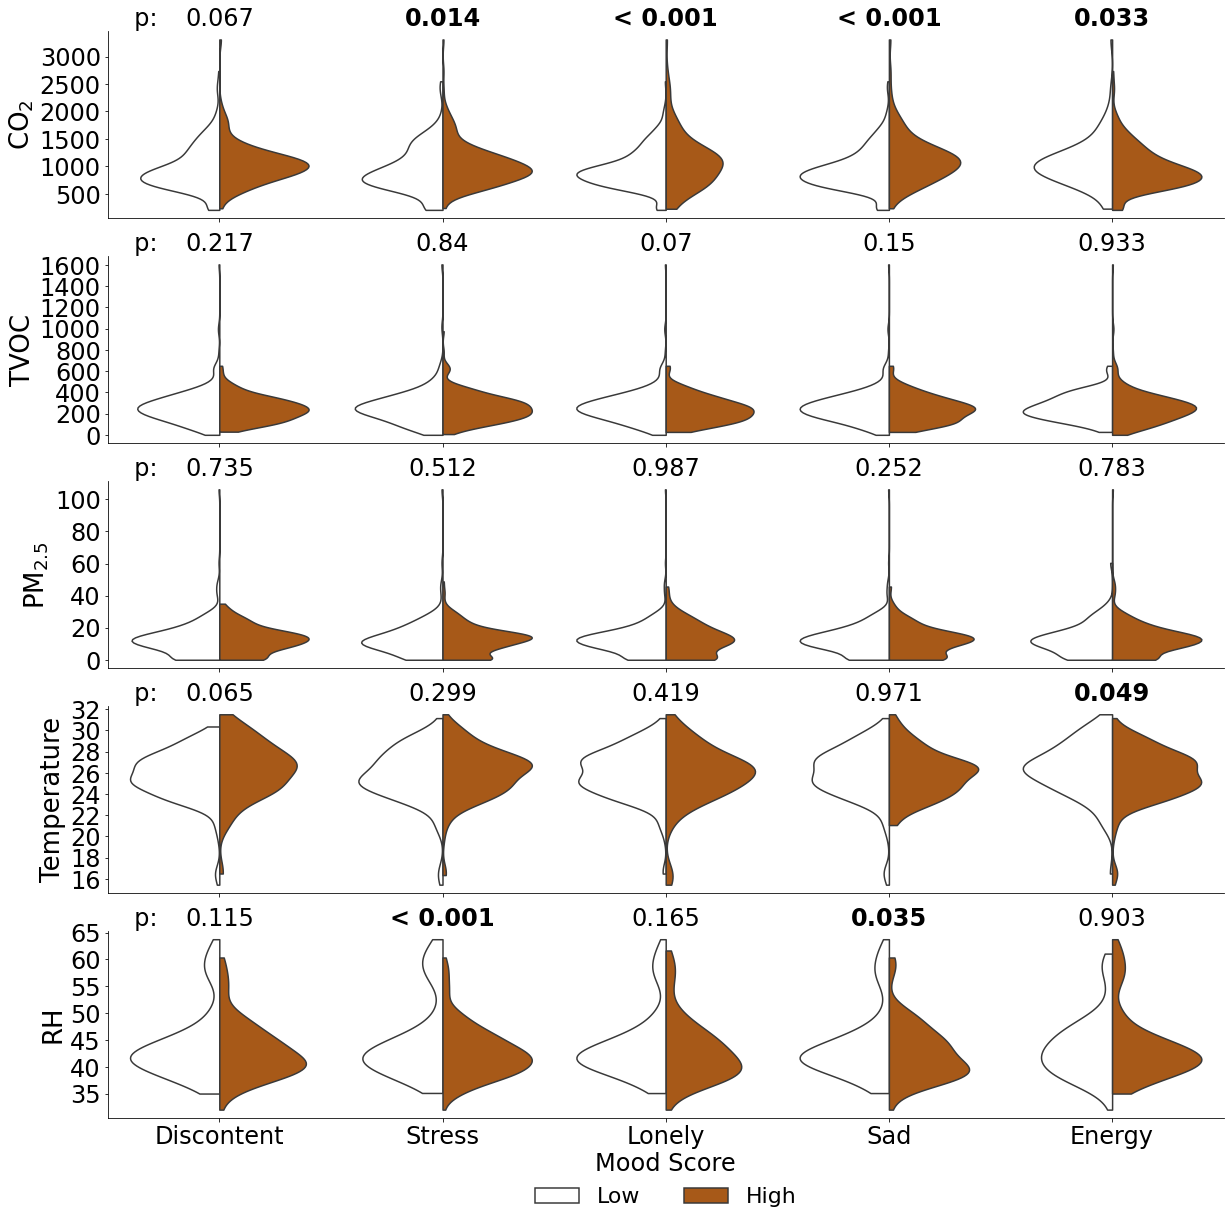

In [65]:
ieq_dist_ttest = plot_mood_violin_per_ieq(ema_bi_ieq,summary_stat="mean",label="home",save=True)
res = ieq_dist_ttest["co2"]
res["Delta CO_2"] = round(res["mean_high"] - res["mean_low"],2)
res.drop(["mean_low","mean_high"],axis="columns",inplace=True)
res=res.reindex(columns=["low","high","Delta CO_2","p"])
res["p"] = round(res["p"],3)
for ieq_param in ["pm2p5_mass","temperature_c","rh"]:
    temp = ieq_dist_ttest[ieq_param]
    temp[f"Delta {ieq_param}"] = round(temp["mean_high"] - temp["mean_low"],2)
    temp.drop(["low","high","mean_low","mean_high"],axis="columns",inplace=True)
    temp = temp.reindex(columns=[f"Delta {ieq_param}","p"])
    temp["p"] = round(temp["p"],3)
    res = res.merge(temp,left_index=True,right_index=True)

In [66]:
print(res.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  low &  high &  Delta CO\_2 &    p\_x &  Delta pm2p5\_mass &    p\_y &  Delta temperature\_c &    p\_x &  Delta rh &    p\_y \\
mood       &      &       &             &        &                   &        &                      &        &           &        \\
\midrule
Discontent &  589 &   232 &       82.91 &  0.067 &             -0.38 &  0.735 &                 0.51 &  0.065 &     -1.11 &  0.115 \\
Stress     &  374 &   447 &      101.58 &  0.014 &             -0.68 &  0.512 &                 0.26 &  0.299 &     -2.30 &  0.000 \\
Lonely     &  552 &   269 &      151.29 &  0.001 &             -0.02 &  0.987 &                -0.23 &  0.419 &     -1.00 &  0.165 \\
Sad        &  578 &   243 &      209.32 &  0.000 &             -1.34 &  0.252 &                -0.01 &  0.971 &     -1.53 &  0.035 \\
Energy     &  200 &   621 &     -101.73 &  0.033 &              0.33 &  0.783 &                -0.56 &  0.049 &      0.09 &  0.903 \\
\bottomrule
\end

### Individual Relationship

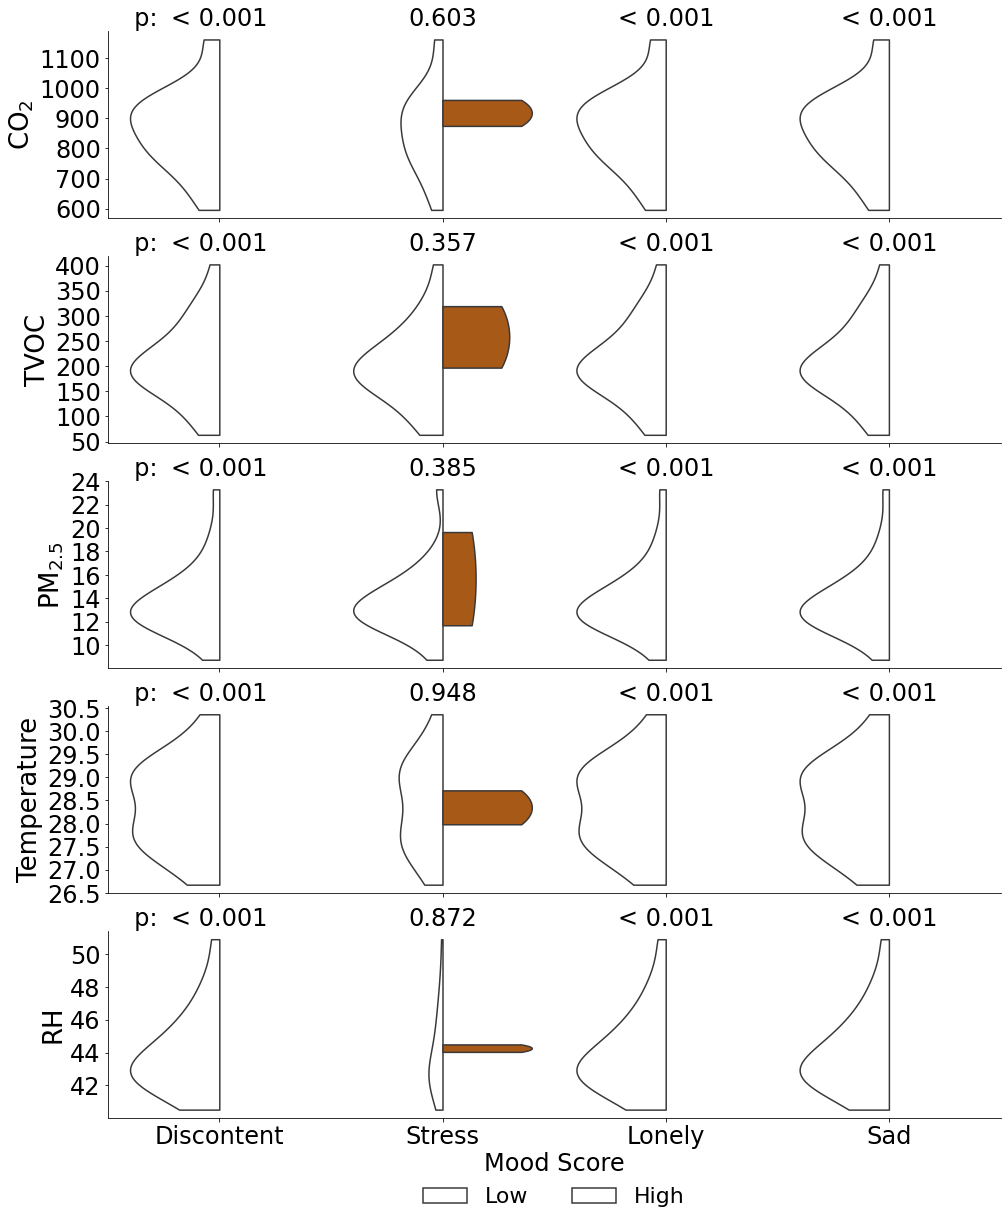

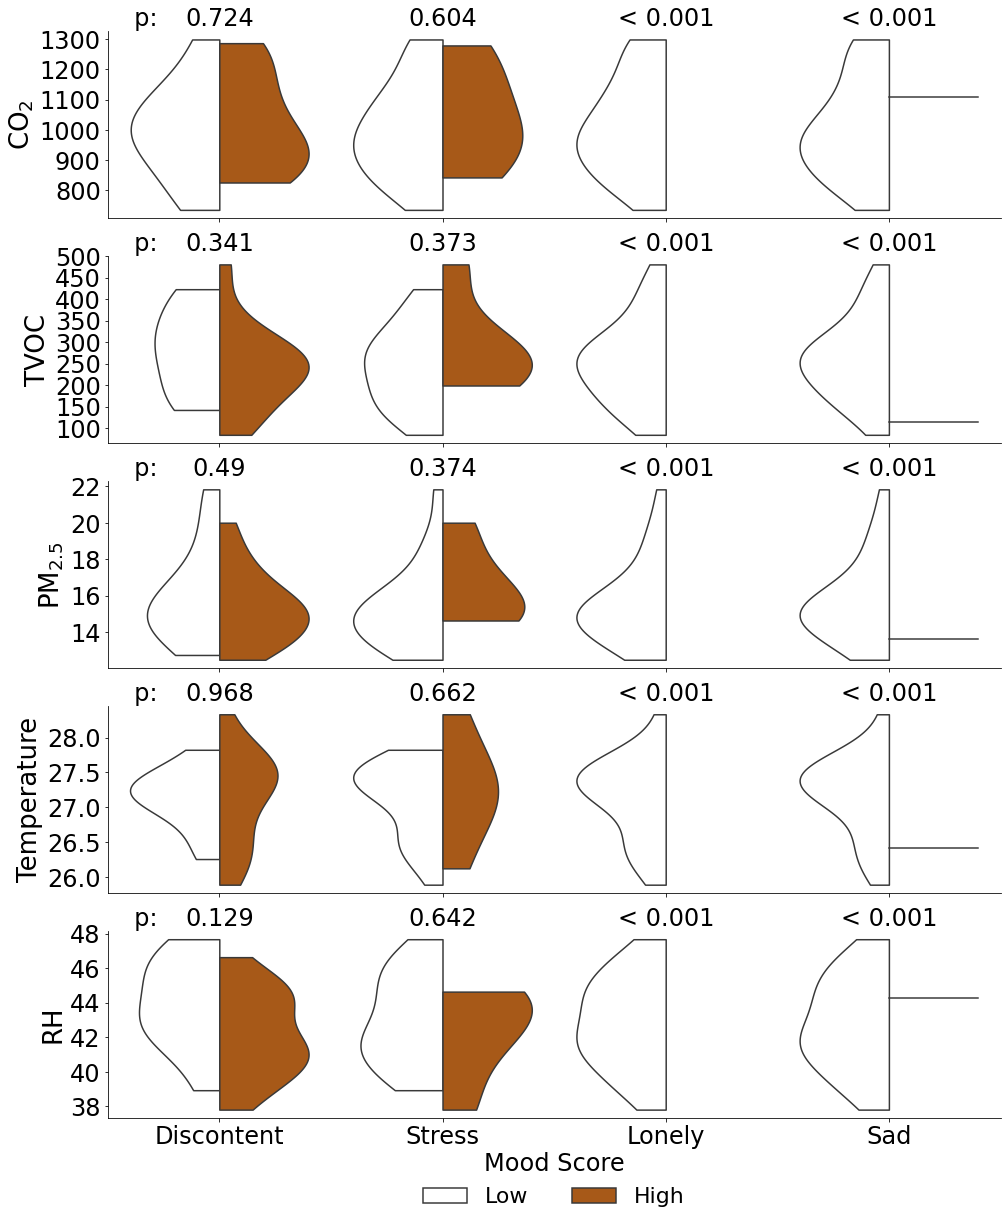

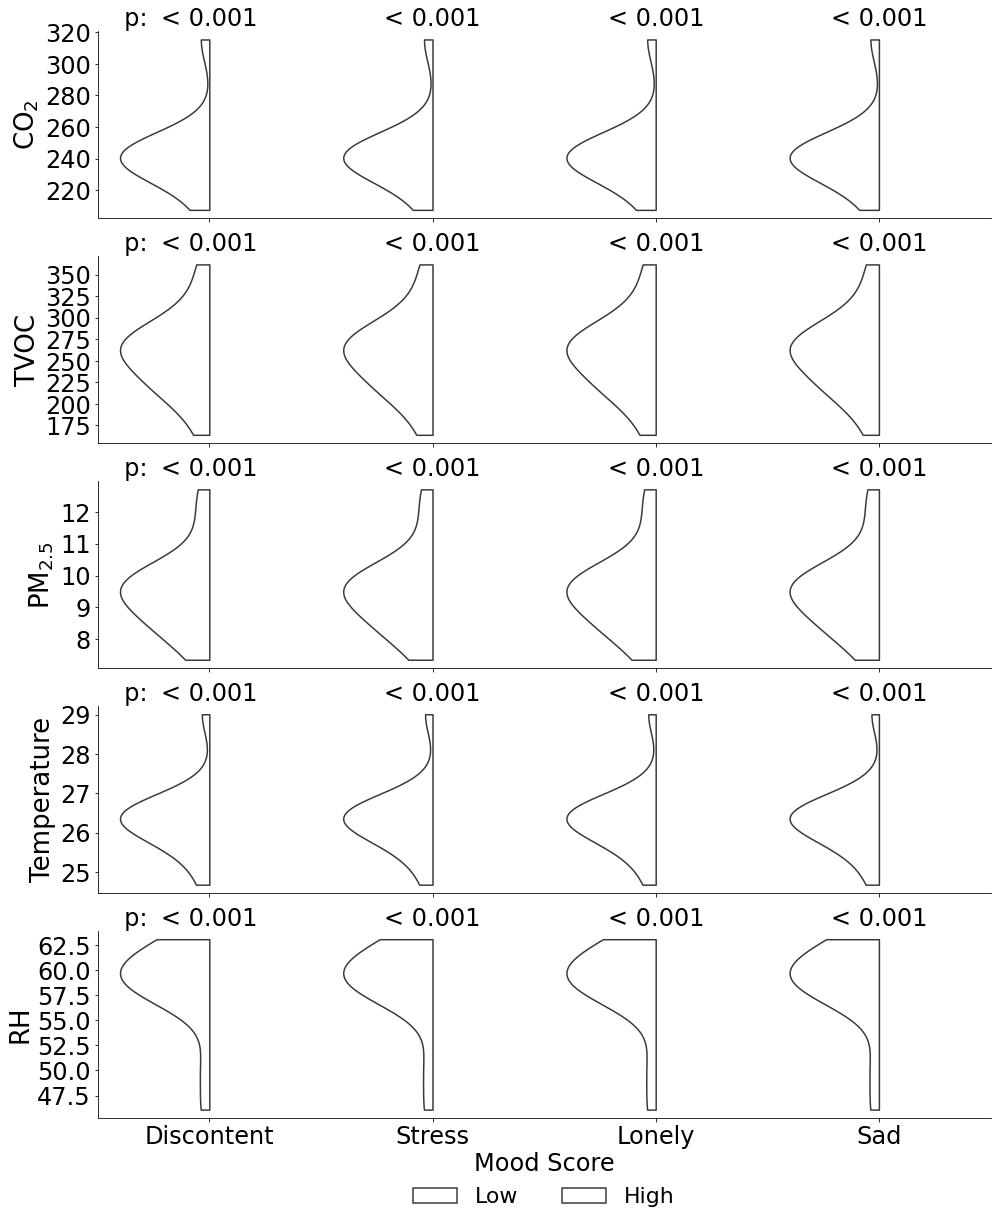

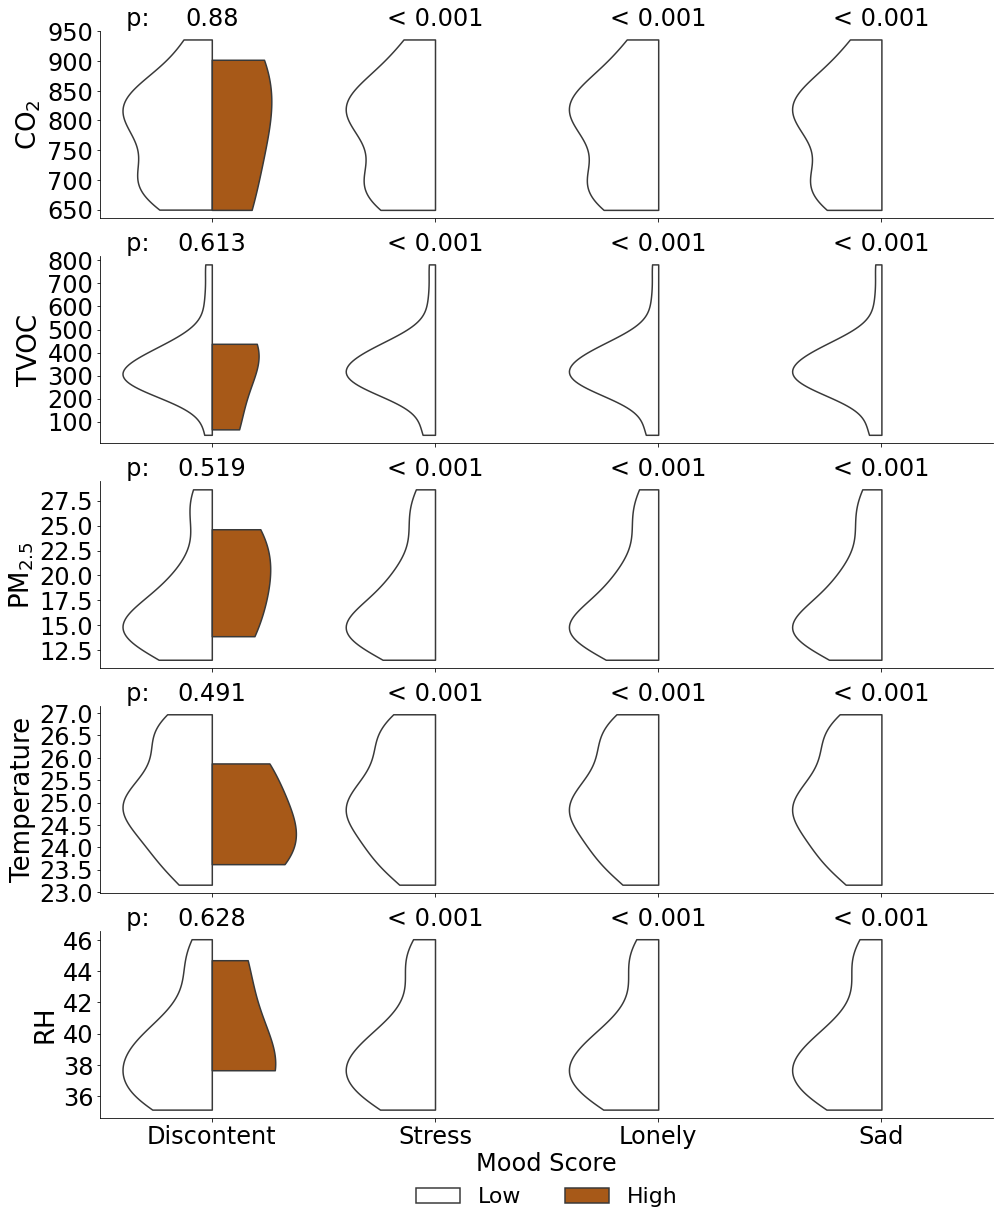

In [21]:
for pt in ema_bi_ieq["beiwe"].unique():
    ema_bi_ieq_pt = ema_bi_ieq[ema_bi_ieq["beiwe"] == pt]
    if len(ema_bi_ieq_pt) > 40:
        ieq_dist_ttest = plot_mood_violin_per_ieq(ema_bi_ieq_pt,summary_stat="mean")

<div class="alert alert-block alert-danger">

We don't have a sufficient amount of data to test the effects on an individual level.
    
</div>

[Back to Analysis](#analysis)

---

<a id='ieq_and_mood'></a>

## IEQ and Mood

In [22]:
def study_ieq_and_mood(df_ieq,df_mood,ieq_params=["co2","tvoc","pm2p5_mass","temperature_c","rh"],moods=["discontent","stress","lonely","sad"],ieq_stat="mean",mood_stat="mean",plot=False,save=False):
    """
    Scatters the IEQ and mood during the entire study
    
    Parameters
    ----------
    
    Returns
    -------
    results : DataFrame
    """
    res = {key: [] for key in ieq_params + moods}
    res["beiwe"] = []
    res["n"] = []
    for pt in df_ieq["beiwe"].unique():
        ieq_pt = df_ieq[df_ieq["beiwe"] == pt]
        mood_pt = df_mood[df_mood["beiwe"] == pt]
        if len(ieq_pt) > 0 and len(mood_pt) > 0:
            res["beiwe"].append(pt)
            res["n"].append(len(mood_pt))
            if ieq_stat == "mean":
                c = (np.nanmean,{})
            elif ieq_stat == "std":
                c = (np.nanstd,{})
            elif isinstance(ieq_stat,int):
                c = (np.nanpercentile,{"q":ieq_stat})
            for ieq_param in ieq_params:
                f, kwargs = c
                res[ieq_param].append(f(ieq_pt[ieq_param],**kwargs))
            for mood in moods:
                res[mood].append(np.nanmean(mood_pt[mood]))
                
    results = pd.DataFrame(res)
    if plot:
        cmap = "coolwarm_r"
        fig, axes = plt.subplots(len(moods),len(ieq_params),figsize=(3*len(ieq_params),3*len(moods)),sharex="col",sharey="row",gridspec_kw={"wspace":0.05,"hspace":0.05})
        for r, mood in enumerate(moods):
            axes[r,0].set_ylabel(mood.title(),fontsize=14)
            axes[r,0].set_ylim([-0.5,3.5])
            axes[r,0].set_yticks(np.arange(0,4,1))
            axes[r,0].set_yticklabels(np.arange(0,4,1),fontsize=12)
            for c, ieq_param in enumerate(ieq_params):
                data = results[[ieq_param,mood,"n"]]
                data.dropna(inplace=True)
                X = data[ieq_param].values
                y = data[mood].values
                sc = axes[r,c].scatter(X,y,c=data["n"],edgecolor="black",cmap=cmap,alpha=0.50,s=100,zorder=10)
                reg = LinearRegression().fit(X.reshape(-1, 1),y)
                axes[r,c].plot(X,reg.predict(X.reshape(-1, 1)),color="black",lw=2,zorder=1)
                #axes[r,c].text(np.min(X),3,round(reg.score(X.reshape(-1,1),y),2),ha="left",size=10)
                for loc in ["top","right"]:
                    axes[r,c].spines[loc].set_visible(False)
                
                if r == len(moods)-1:
                    axes[r,c].set_xlabel(visualize.get_label(ieq_param),fontsize=14)
                    labels = []
                    for t in axes[r,c].get_xticks():
                        labels.append(int(t))
                    axes[r,c].set_xticklabels(labels,fontsize=12)
                    
        cbar = fig.colorbar(sc, ax=axes.ravel().tolist())
        cbar.ax.set_title("EMAs")
        
        if save:
            plt.savefig(f"../reports/figures/beacon-beiwe-ieq_{ieq_stat}_study-mood_{mood_stat}_home-scatter-ux_s20.pdf",bbox_inches="tight")
        plt.show()
        plt.close()
    return results

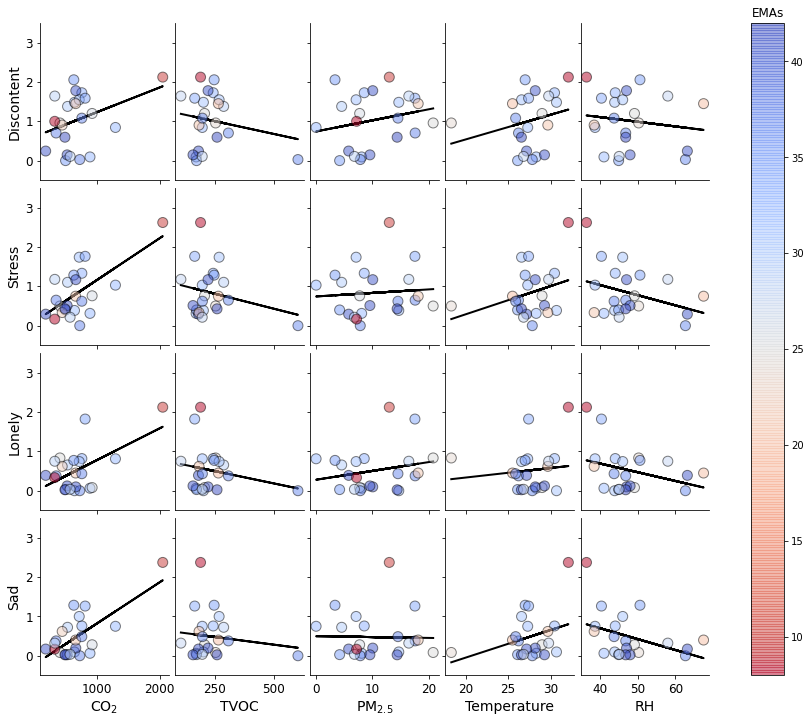

In [23]:
res = study_ieq_and_mood(ieq,ema,ieq_stat=90,plot=True,save=True)

In [24]:
print("Number of Participants:", len(res))

Number of Participants: 24


[Back to Analysis](#analysis)

---

<a id='time_dependence'></a>

## Time Dependence on Exposure at Home on Mood
With the amount of time at home, we can use this time to see if the mood scores are influenced by the time the participant is exposed to the pollution at home.

### Time at Home Only
We can start by looking at the time at home in a vacuum without considering IEQ's effect at all.

In [90]:
def plot_mood_on_time(df,moods=["discontent","stress","lonely","sad"],stat="mean",interval=15,max_t=600):
    """"""
    fig, axes = plt.subplots(len(moods),1,figsize=(18,3*len(moods)),sharex=True)
    for mood, ax in zip(moods,axes):
        df["minutes_at_home"] = df["time_at_home"] / 60
        scores = []
        ns = []
        for cutoff1, cutoff2 in zip(np.arange(0,max_t-interval,interval),np.arange(interval,max_t,interval)):
            ema_by_cutoff = df[(df["minutes_at_home"] >= cutoff1) & (df["minutes_at_home"] <= cutoff2)]
            if stat == "median":
                scores.append(ema_by_cutoff.median(axis=0)[mood])
            else: #defaults to mean
                scores.append(ema_by_cutoff.mean(axis=0)[mood])
            ns.append(len(ema_by_cutoff))

        sc = ax.scatter(np.arange(interval,max_t,interval),scores,s=100,c=ns,cmap=plt.cm.get_cmap("coolwarm_r", 8),vmin=0,vmax=80,edgecolor="black")
        ax.set_title(mood.title(),fontsize=22,pad=0)

        ax.set_xticks(np.arange(0,max_t,interval))

        ax.set_ylim([-0.5,3.5])
        ax.set_yticks(np.arange(0,4,1))
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.tick_params(labelsize=18)
            
    ax.set_xlabel("Minutes since arriving home",fontsize=20)
    cbar = plt.colorbar(sc,ax=axes.ravel().tolist(),shrink=0.75)
    cbar.ax.set_title("EMAs",fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    plt.show()
    plt.close()

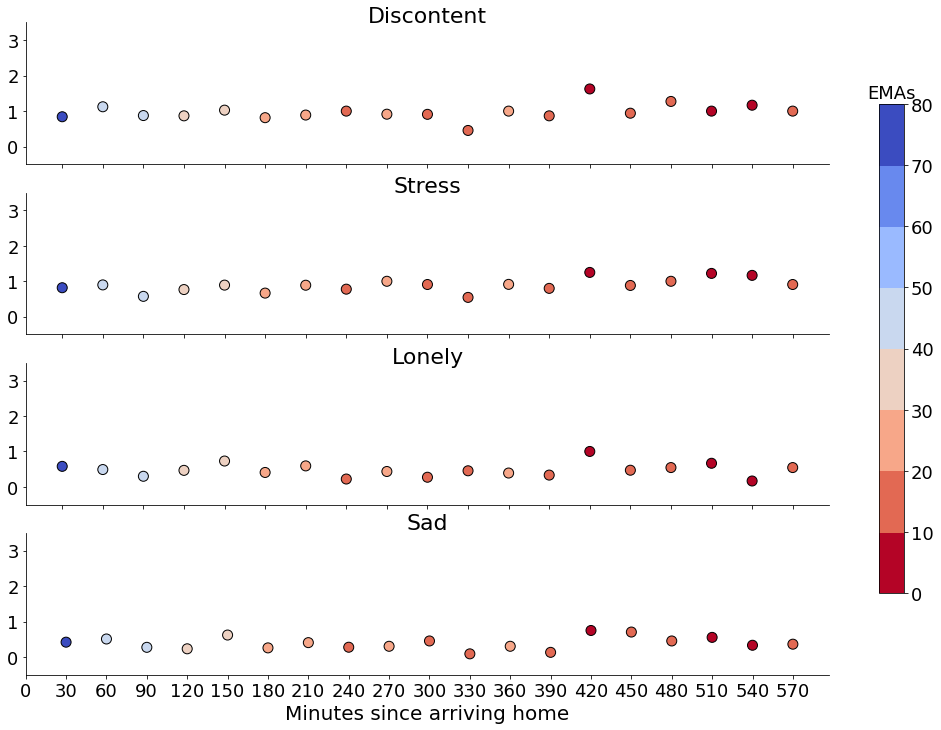

In [91]:
plot_mood_on_time(ema,interval=30)

<div class="alert alert-block alert-danger">

There does not seem to be a major relationship between the mood and the amount of time spent at home.
    
</div>

### Time at Home and Exposure
We can now use the time at home and see if the exposure to IEQ parameters factors into the mood that participants report.

In [33]:
def get_inhalation_rate(pt):
    """
    Gets inhalation rates for the given participant using EPA data:
    source: www.epa.gov/sites/default/files/2015-09/documents/efh-chapter06.pdf
    
    Parameters
    ----------
    pt : str
        Beiwe ID
    
    Returns
    -------
    <rate> : float
        inhalation rate in liters/minute
    """
    info = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx")
    mass = info[info["beiwe"] == pt]["mass"].values[0]
    sex = info[info["beiwe"] == pt]["sex"].values[0]
    if sex[0].lower() == "m": # male rate
        return 6.2e-5 * 1000 * mass
    elif sex[0].lower() == "f": # female rate
        return 6.2e-5 * 1000 * mass
    else:
        return np.nan

In [34]:
def convert_exposure(iaq_param,value):
    """
    Converts the IAQ parameter into more digestible units
    
    Parameters
    ----------
    iaq_param : {"co2","pm2p5","tvoc"}
        specifies which IAQ parameter to convert
    value : float
        value of the corresponding IAQ parameter in "standard" units
    
    Returns
    -------
    <output> : float
        converted parameter value
    """
    vol_air = 24.45
    
    if iaq_param == "co2":
        return value / 10e6 / vol_air * 44 * 1000
    elif iaq_param == "pm2p5": # assuming mass for now
        return value / 1000 / 1000
    elif iaq_param == "tvoc":
        return value / 10e9 / vol_air
    else:
        return value

In [35]:
def get_exposure(df_in,exposure_min_t=0,exposure_max_t=180,summary_stat="mean",convert=False,scale=False):
    """
    Calculates the concentration exposure amount over a given interval
    
    Parameters
    ----------
    df_in : DataFrame
        Must contain columns {"beiwe","time_at_home"} and at least one column with IEQ parameters
        ending in the provided summary_stat
    exposure_min_t : int, default 0
        MINIMUM exposure period (in minutes) i.e. minimum time at home before submitting EMA
    exposure_max_t : int, default 180
        MAXIMUM exposure period (in minutes) i.e. maximum time at home before submitting EMA
    summary_stat : {"mean","delta","max","sum"}, default "mean"
        IEQ summary stat to consider 
    
    Returns
    -------
    df_exposure : DataFrame 
        Original datafame with calculated exposure concentrations for IEQ parameters as
        separate columns
    """
    df = df_in.copy()
    df["mins_at_home"] = df["time_at_home"] / 60
    df = df[(df["mins_at_home"] >= exposure_min_t) & (df["mins_at_home"] <= exposure_max_t)]
    df_exposure = df.copy()
    for ieq_param in [c for c in df.columns if c.endswith(summary_stat)]:
        ieq_param_short = ieq_param.split("_")[0]
        if ieq_param_short in ["co2","tvoc","co","no2","pm2p5"]:
            if convert:
                df[ieq_param] = df.apply(lambda row: convert_exposure(ieq_param_short,row[ieq_param]),axis=1)
            if scale:
                df["in_rate"] = df.apply(lambda row: get_inhalation_rate(row["beiwe"]),axis=1)
                df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param] * df["in_rate"]
            else:
                df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param]
        else: # temperature or rh
            df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param]
        
    df_exposure.drop([col for col in df_exposure.columns if col.split("_")[-1] in ["mean","delta","max","sum"]],axis="columns",inplace=True)
    return df_exposure

In [36]:
#temp = get_exposure(ema_ieq,summary_stat="sum",convert=False)
#temp.head()

In [37]:
def plot_exposure_violin(df,mood="content",ieq_param="co2"):
    """Plots the distribution of exposure (mean*hours at home) for the given mood scores"""
    _, ax = plt.subplots(figsize=(8,4))
    sns.violinplot(x=mood,y=f"{ieq_param}_exposure",data=df,
                   cut=0,inner=None,scale="area",ax=ax)
    ax.set_xlabel(mood.title())
    ax.set_ylabel(f"{ieq_param.upper()} Exposure (concentration-hours)")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    plt.show()
    plt.close()

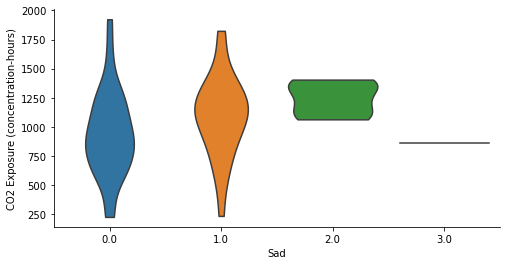

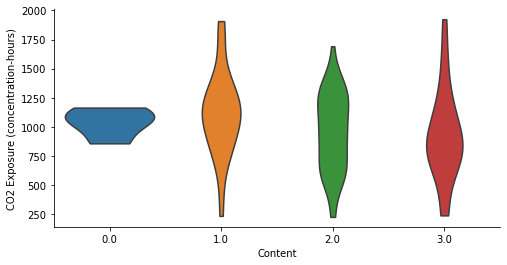

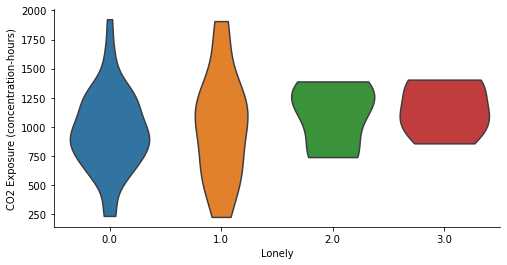

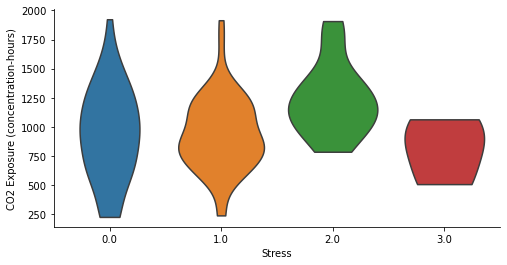

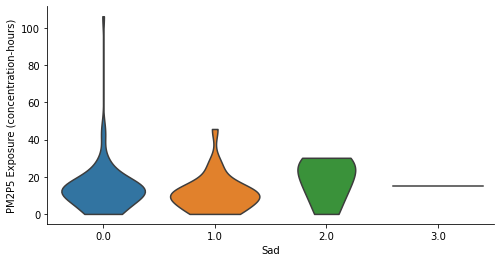

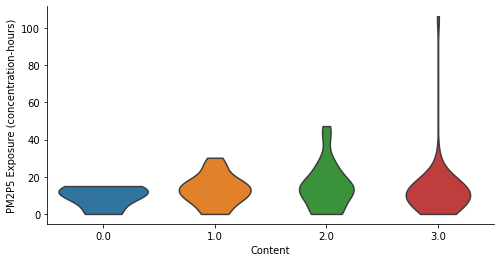

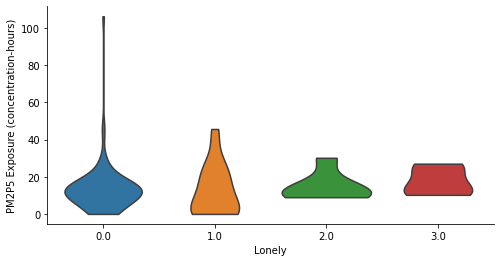

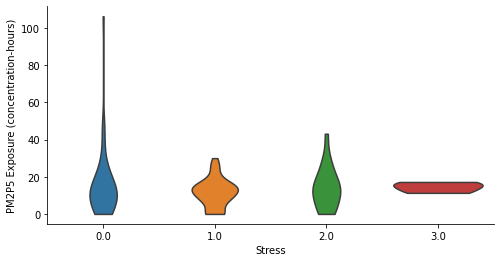

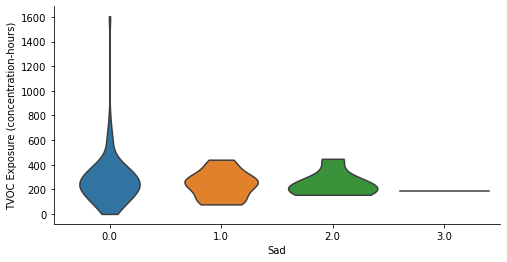

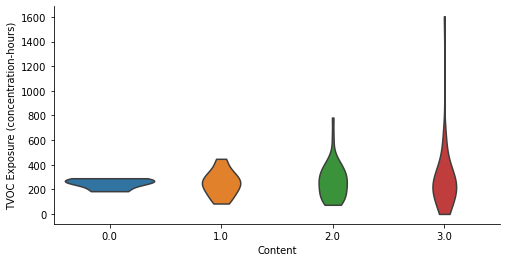

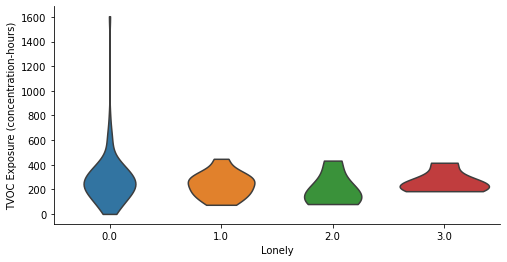

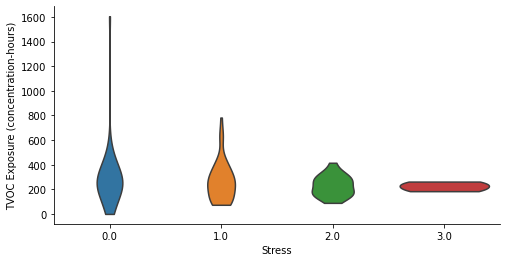

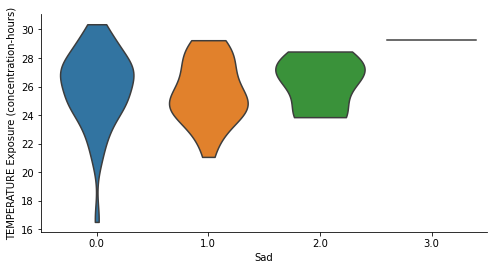

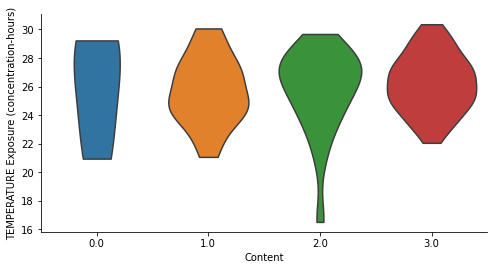

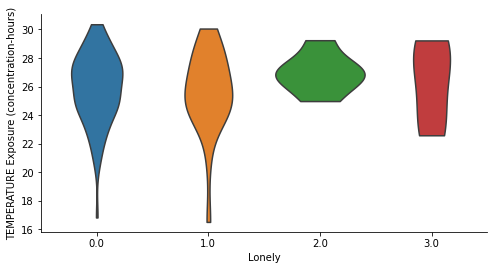

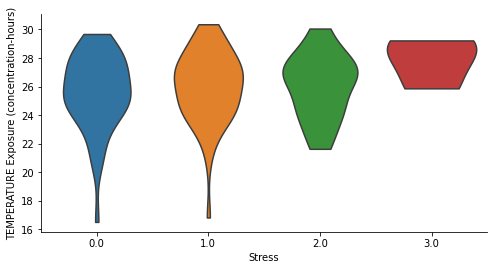

In [38]:
for ieq_param in ["co2","pm2p5","tvoc","temperature"]:
    for mood in ["sad","content","lonely","stress"]:
        plot_exposure_violin(get_exposure(ema_ieq), mood=mood,ieq_param=ieq_param)

In [74]:
def plot_exposure_bimood_violin(df_in,ieq_params=["co2","tvoc","pm2p5","temperature","rh"],moods=["discontent","stress","lonely","sad"],save=False):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    # creating dictionary to store p-values
    ttest_results = {}
    fig, axis = plt.subplots(len(ieq_params),1,figsize=(4*len(moods),4*len(ieq_params)),sharex=True)
    if len(ieq_params) == 1:
        axes = [axis]
    else:
        axes = axis.flat
    for ieq_param, title, ax in zip(ieq_params,["a","b","c","d","e","f"],axes):
        df_expanded = df_in.melt(id_vars=[c for c in df_in.columns if c.endswith("exposure")],value_vars=moods)
        #return df_expanded
        g = sns.violinplot(x="variable",y=f"{ieq_param}_exposure",hue="value",data=df_expanded,
                       split=True,inner=None,hue_order=[0,1],palette={0:"white",1:"#bf5700"},cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([mood.title() for mood in moods],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(ieq_param),fontsize=label_fs)
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        if ieq_param == "rh":
            ax.legend(handles=g.get_children(),labels=[f"Low",f"High"],loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Mood Score")
        else:
            ax.get_legend().remove()
        
        pvals = pd.DataFrame()
        for mood in moods:
            df = df_expanded[df_expanded["variable"] == mood]
            low_vals = df[df["value"] == 0]
            high_vals = df[df["value"] == 1]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[f"{ieq_param}_exposure"],high_vals[f"{ieq_param}_exposure"], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"mood":[mood],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[f"{ieq_param}_exposure"])],"mean_high":np.nanmean(high_vals[f"{ieq_param}_exposure"]),"p_val":[p]}))

        ttest_results[ieq_param] = pvals.set_index("mood")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[ieq_param]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
        
    plt.show()
    plt.close()
    
    return ttest_results

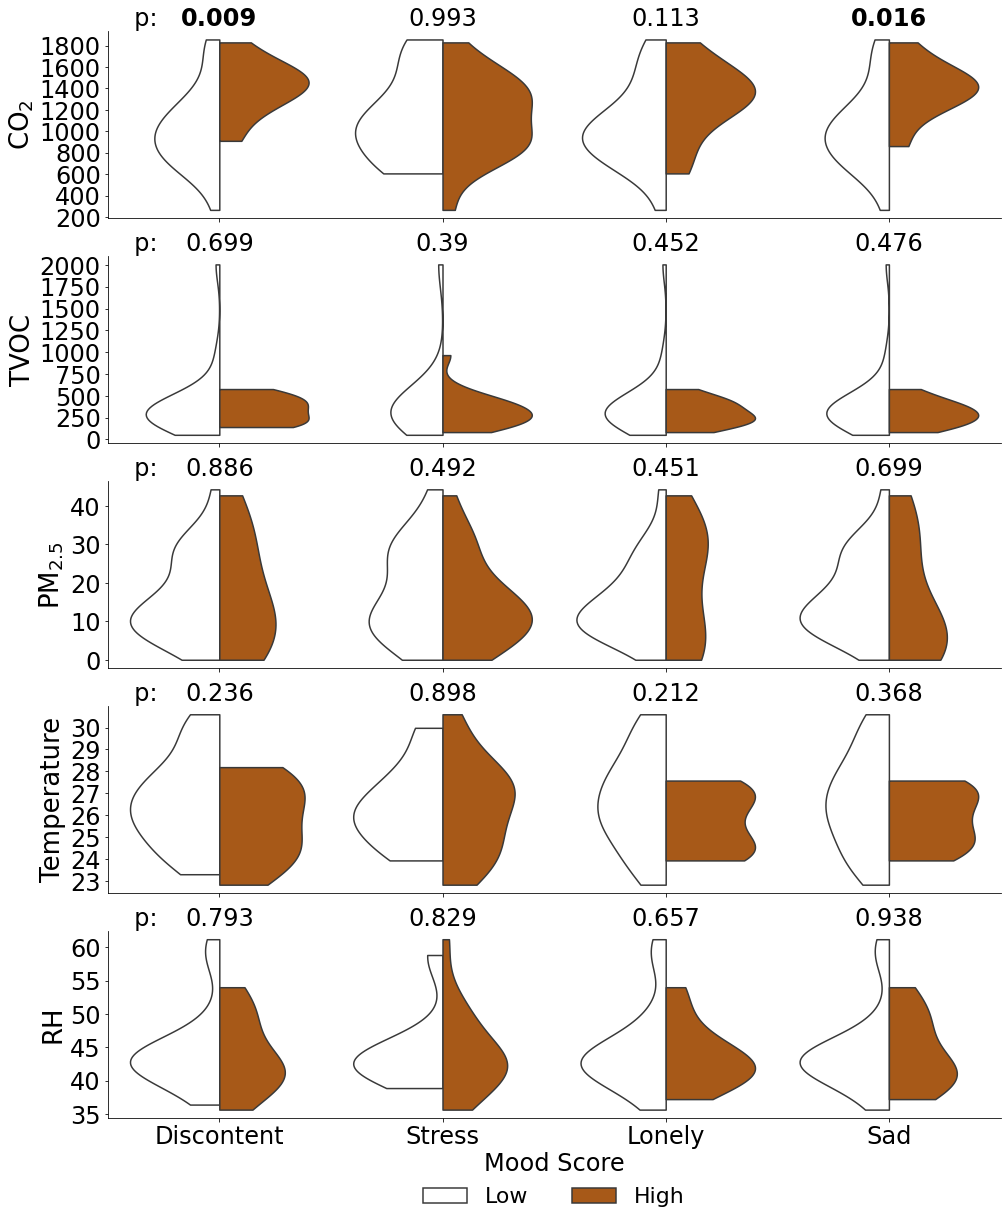

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent   65    23  1029.171151  1413.458573  0.008769
stress       34    54  1130.175468  1131.397469  0.992969
lonely       54    34  1062.374646  1295.341442  0.112621
sad          60    28  1036.821332  1392.208070  0.016237, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent   65    23  390.654503  339.476005  0.698989
stress       34    54  434.600750  334.664493  0.390431
lonely       54    34  404.897913  308.985329  0.452387
sad          60    28  401.669780  307.654092  0.476275, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent   65    23  16.393894  17.073244  0.885661
stress       34    54  18.201939  15.343568  0.491803
lonely       54    34  15.588205  19.019531  0.450913
sad          60    

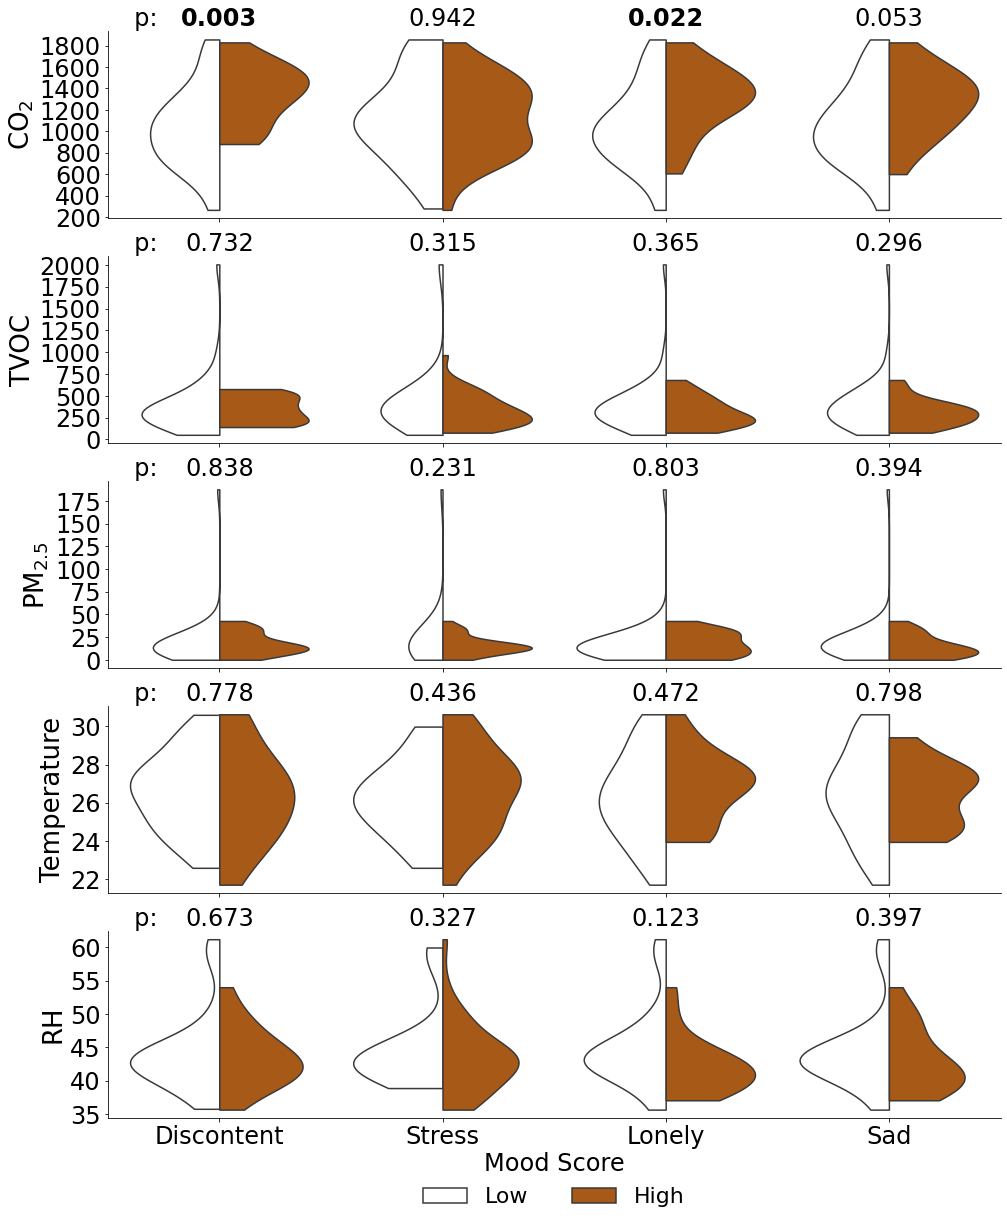

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent   96    41  1032.998865  1349.092329  0.003491
stress       53    84  1125.652899  1133.584814  0.941570
lonely       85    52  1052.787428  1304.859070  0.021790
sad          91    46  1061.566958  1272.808279  0.052601, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent   96    41  375.418570  346.504255  0.732455
stress       53    84  416.914342  336.477011  0.314640
lonely       85    52  389.835040  313.431177  0.364765
sad          91    46  394.497968  307.831877  0.295776, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent   96    41  19.487279  17.964543  0.838196
stress       53    84  24.293669  15.863831  0.230907
lonely       85    52  19.589630  17.729738  0.803021
sad          91    

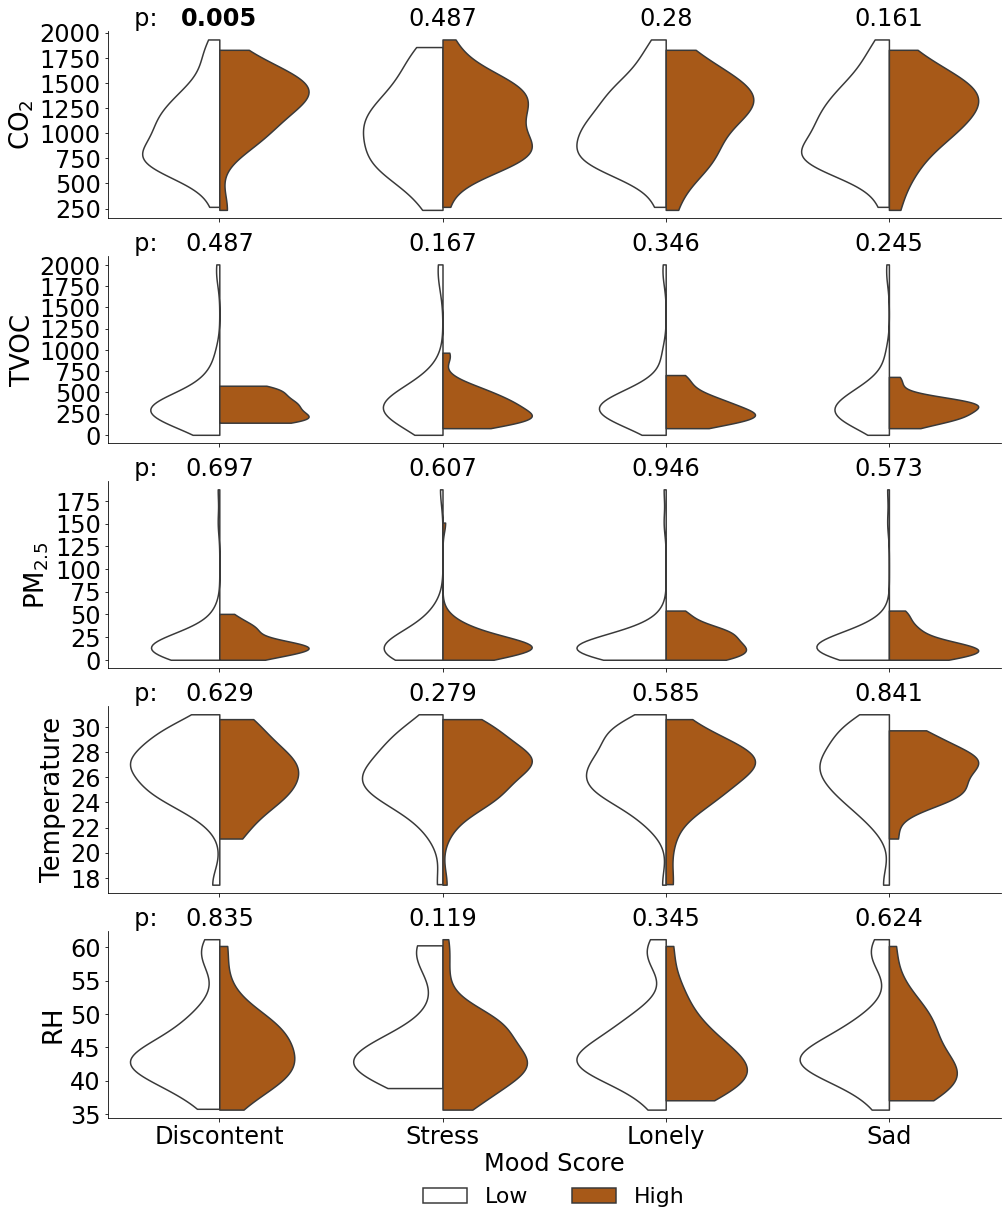

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent  130    47  1018.598065  1289.983275  0.005450
stress       73   104  1051.581377  1115.385277  0.486948
lonely      116    61  1061.680180  1167.984018  0.279741
sad         122    55  1052.846505  1190.469738  0.160599, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent  130    47  390.336385  335.047148  0.487126
stress       73   104  436.419412  337.486430  0.166630
lonely      116    61  396.732274  324.004226  0.346464
sad         122    55  401.578062  311.995101  0.245485, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent  130    47  21.218032  18.504135  0.696701
stress       73   104  22.483626  19.254252  0.607435
lonely      116    61  20.637242  20.179475  0.946106
sad         122    

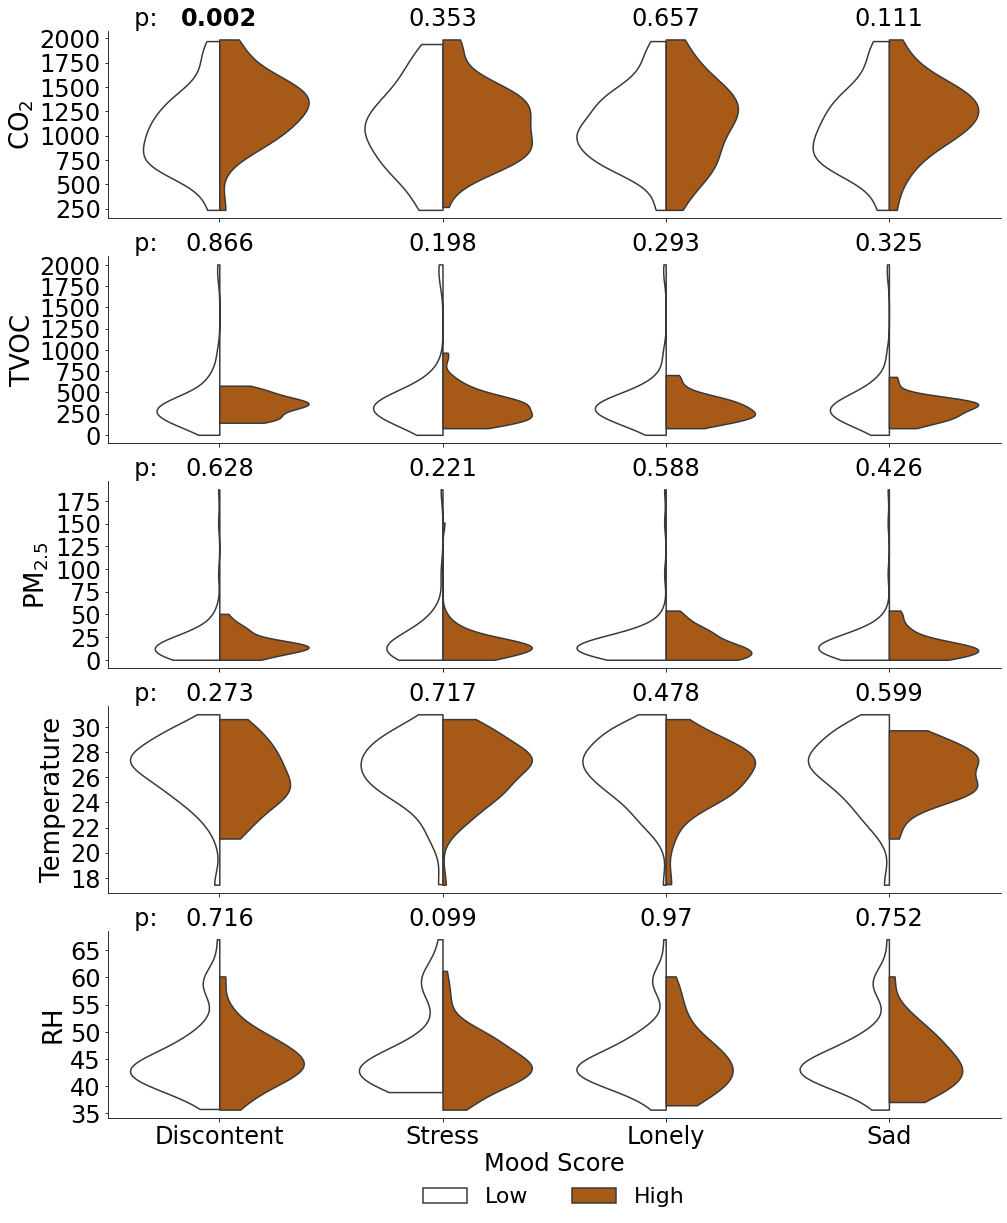

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent  179    65  1035.169133  1302.708138  0.001817
stress      100   144  1061.166359  1136.042813  0.353187
lonely      156    88  1096.789462  1134.605643  0.657256
sad         167    77  1070.275984  1209.089869  0.111496, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent  179    65  356.920824  347.007887  0.866023
stress      100   144  396.529282  327.927319  0.198088
lonely      156    88  372.299054  312.894645  0.292649
sad         167    77  370.073587  312.960761  0.325037, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent  179    65  19.519280  16.923642  0.628169
stress      100   144  22.491138  16.538714  0.221240
lonely      156    88  19.672722  16.876996  0.588035
sad         167    

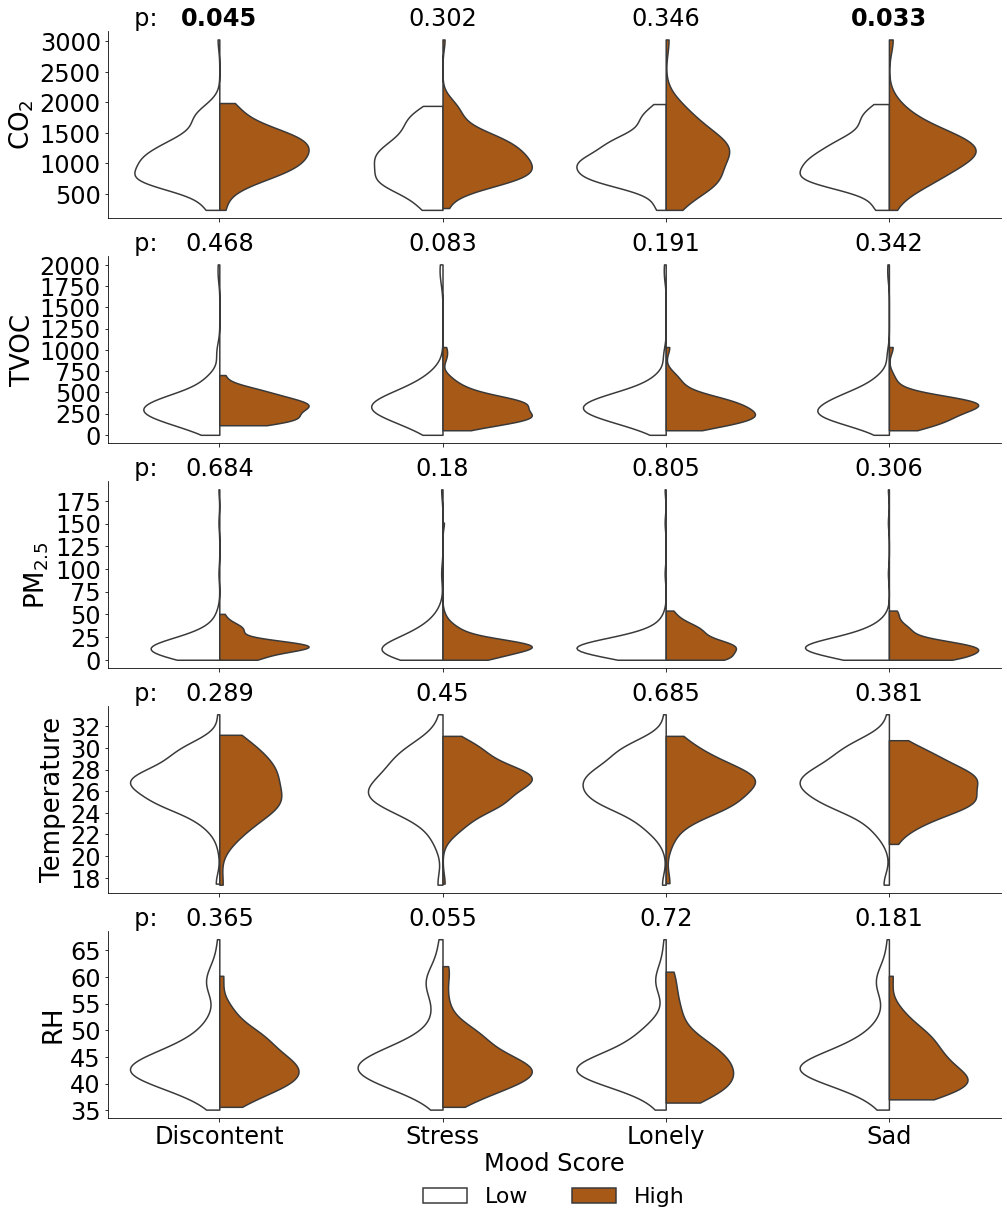

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent  283   101  1052.721130  1197.106687  0.045094
stress      164   220  1048.764234  1116.823250  0.301612
lonely      253   131  1071.630576  1137.768060  0.345953
sad         273   111  1050.849679  1205.575070  0.032835, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent  283   101  358.413721  328.511508  0.468336
stress      164   220  390.005431  325.521685  0.082821
lonely      253   131  365.979502  314.052842  0.190697
sad         273   111  360.851425  321.717057  0.342317, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent  283   101  17.690822  16.253479  0.684228
stress      164   220  19.940917  15.665261  0.179843
lonely      253   131  17.562767  16.720631  0.804766
sad         273   1

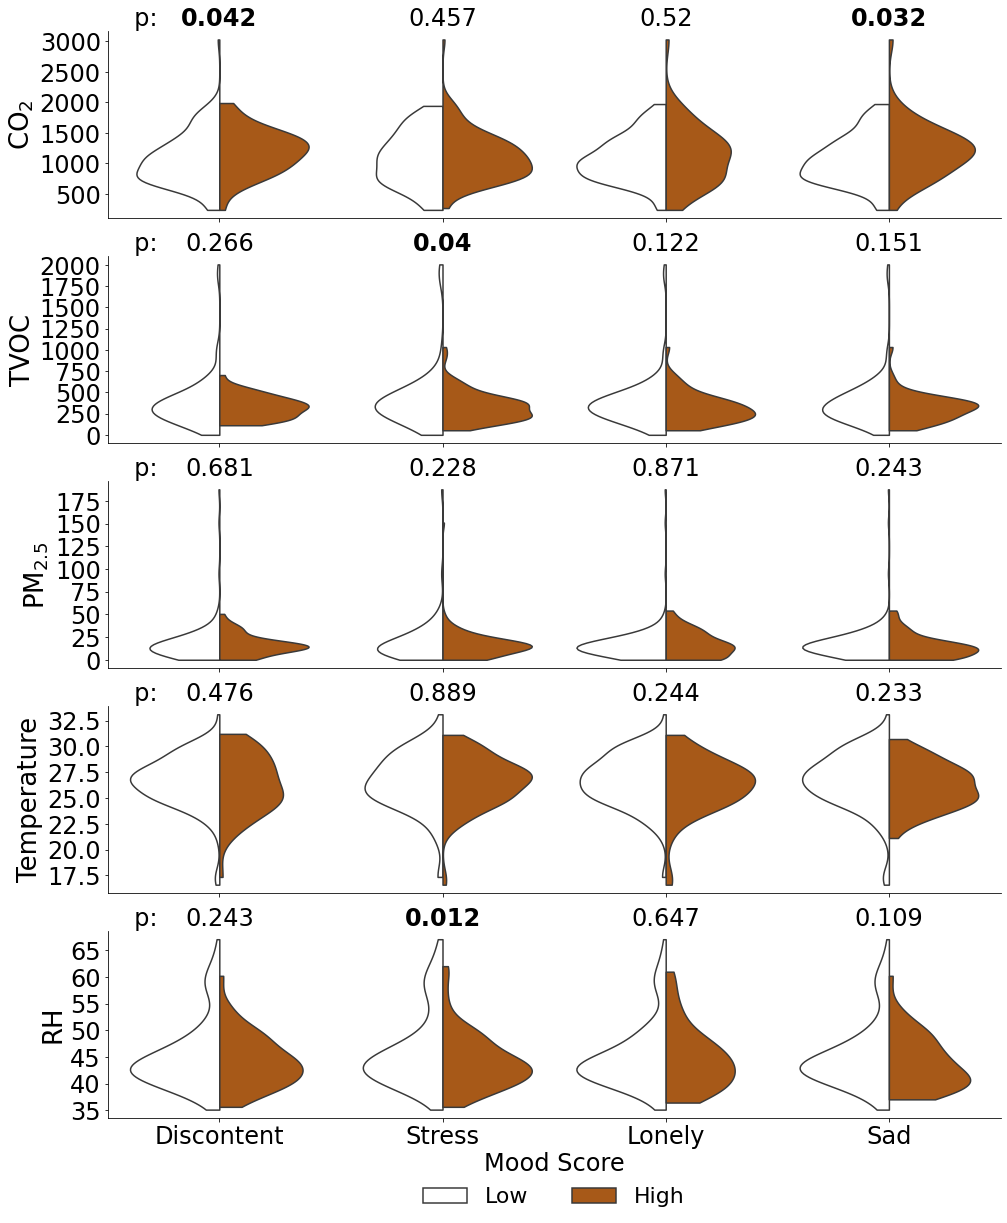

{'co2':             low  high     mean_low    mean_high     p_val
mood                                                     
discontent  298   109  1058.386082  1197.043574  0.042379
stress      173   234  1066.723607  1113.085703  0.456651
lonely      268   139  1082.859783  1125.997628  0.520052
sad         290   117  1057.325231  1205.799016  0.031804, 'tvoc':             low  high    mean_low   mean_high     p_val
mood                                                   
discontent  298   109  376.419502  328.292222  0.265943
stress      173   234  412.149799  332.231520  0.039882
lonely      268   139  382.542911  317.608819  0.121815
sad         290   117  379.864992  317.475576  0.151437, 'pm2p5':             low  high   mean_low  mean_high     p_val
mood                                                 
discontent  298   109  17.704265  16.356491  0.681124
stress      173   234  19.513269  15.956631  0.228391
lonely      268   139  17.499405  16.981661  0.870938
sad         290   1

In [148]:
for t in [30,60,90,150,360,420]:
    res = plot_exposure_bimood_violin(get_exposure(ema_bi_ieq,exposure_max_t=t,summary_stat="0.9"))#,moods=["discontent","lonely","sad"],ieq_params=["co2"])
    print(res)

<div class="alert alert-block alert-success">

The only relationship that shows a significant relationship throughout the various exposure periods is `co2` and the level of discontent. This relationship is also evident to a lesser degrees for `sad`.
    
</div>

[Back to Analysis](#analysis)

---

<a id='contigency'></a>

## Contigency Tables
With the contigency tables, we address any participant bias that might have slipped into the previous analysis because of one participant having better or worse IAQ conditions.

With both mood and IEQ binarized, we can create the contigency tables and visualize them. Python even has a built-in function for this: [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html).

See more [here](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

We try two metrics on the contigency table:
1. Matthews Correlation Coefficient (also called the Phi Coefficient)
2. Cramer's V

Turns out these metrics are essentially the same with Cramer's V taking the absolute value of the Matthews Coefficient.

In [80]:
from sklearn.metrics import matthews_corrcoef
import scipy.stats as stats

In [81]:
def calculate_cramers_v(ct):
    """returns Cramers V from the given contingency table"""
    #create 2x2 table
    data = ct.values

    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data)
    minDim = min(data.shape)-1

    #calculate Cramer's V 
    V = np.sqrt((X2/n) / minDim)

    #display Cramer's V
    return V

Getting Contigency Tables and calculating scores.

In [82]:
for mood in ["discontent","sad","lonely","stress"]:
    print(mood.upper())
    #for ieq_param in ["co2","tvoc","pm2p5_mass","temperature_c","rh"]:
    ct = pd.crosstab(columns=ema_bi_ieq_bi[mood],index=[ema_bi_ieq_bi[f"co2_binary"],ema_bi_ieq_bi[f"temperature_c_binary"],ema_bi_ieq_bi[f"pm2p5_mass_binary"],ema_bi_ieq_bi[f"rh_binary"],ema_bi_ieq_bi[f"tvoc_binary"]])
    #print(matthews_corrcoef(ema_bi_ieq_bi[mood],ema_bi_ieq_bi[f"{ieq_param}_binary"]))
    print(round(calculate_cramers_v(ct),3))#,"\t-\t",ieq_param)
    #print(ct)
    print()

DISCONTENT
0.208

SAD
0.21

LONELY
0.232

STRESS
0.22



[Back to Analysis](#analysis)

---

<a id='mood_and_ach'></a>

## Mood and Ventilation
We scatter the summarized mood scores over the study period versus the average ventilation rate determined from the carbon dioxide concentrations.

In [83]:
ach = pd.read_csv("../data/processed/beacon-ventilation_from_ss.csv")

In [84]:
def scatter_ach_and_mood(ach, mood, summary_stat="mean"):
    """"""
    # how to summarize the mood scores
    if summary_stat == "median":
        mood_pt = mood.groupby("beiwe").median()
    elif summary_stat == "std":
        mood_pt = mood.groupby("beiwe").std()
    else:
        mood_pt = mood.groupby("beiwe").mean()
        
    # always averaging the ventilation rates
    ach_pt = ach.groupby("beiwe").std()["ach"]
    
    # merging
    merged = mood_pt[["content","stress","lonely","sad"]].merge(right=ach_pt,left_index=True,right_index=True)
    
    # scattering
    fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
    for m, ax in zip(["content","sad","lonely","stress"],axes.flat):
        ax.scatter(merged["ach"],merged[m],s=50,color="black")
        # x-axis
        ax.set_xlabel("Ventilation Rate (h$^{-1}$)")
        # remainder
        ax.set_title(m.title())
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
    # y-axis
    axes[0].set_ylabel(f"Mood Scored ({summary_stat})")
    plt.show()
    plt.close()
    
    return merged

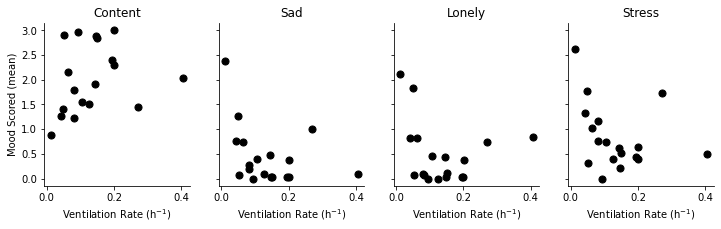

,content,stress,lonely,sad,ach
beiwe,,,,,
745vq78e,2.906250,0.312500,0.062500,0.062500,0.053160
9jtzsuu8,1.516129,0.387097,0.000000,0.096774,0.126161
9xmhtq74,2.972973,0.000000,0.000000,0.000000,0.093973
awa8uces,1.219512,1.170732,0.097561,0.195122,0.081519
e73a1pd5,0.875000,2.625000,2.125000,2.375000,0.012665
i31pt4b4,2.156250,1.031250,0.812500,0.750000,0.063641
idbkjh8u,1.550000,0.750000,0.450000,0.400000,0.106068
kyj367pi,2.041667,0.500000,0.833333,0.083333,0.405498
lkkjddam,1.451613,1.741935,0.741935,1.000000,0.270075


In [85]:
scatter_ach_and_mood(ach,ema,summary_stat="mean")

[Return to Analysis](#analysis)